In [384]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(display='diagram')


In [383]:
X, y = load_wine(return_X_y=True, as_frame=True)
data = load_wine()
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [272]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
alcohol                         178 non-null float64
malic_acid                      178 non-null float64
ash                             178 non-null float64
alcalinity_of_ash               178 non-null float64
magnesium                       178 non-null float64
total_phenols                   178 non-null float64
flavanoids                      178 non-null float64
nonflavanoid_phenols            178 non-null float64
proanthocyanins                 178 non-null float64
color_intensity                 178 non-null float64
hue                             178 non-null float64
od280/od315_of_diluted_wines    178 non-null float64
proline                         178 non-null float64
dtypes: float64(13)
memory usage: 18.2 KB


In [273]:
y

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64

In [274]:
y.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

### Let's split the data and reduce it in to two dimensions for visualization.

In [293]:
# X_train_and_cv, X_test, y_train_and_cv, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train_and_cv, y_train_and_cv, test_size=0.20, stratify=y_train_and_cv)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)


In [294]:
z_scorer = StandardScaler()
X_std = z_scorer.fit_transform(X_train)

In [295]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_std)

In [296]:
wine_1 = X_train_pca[y_train==0]
wine_2 = X_train_pca[y_train==1]
wine_3 = X_train_pca[y_train==2]

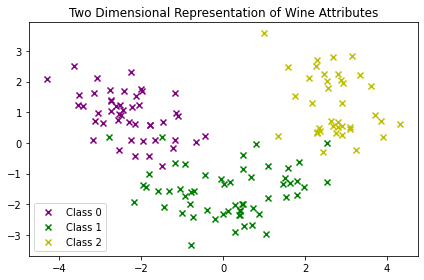

In [297]:
fig, ax = plt.subplots()

for dataset, color, target_name in zip([wine_1, wine_2, wine_3], 
                                       ['purple', 'g', 'y'], 
                                       ['Class 0', 'Class 1', 'Class 2']):
    ax.scatter(dataset[:, 0], dataset[:, 1], marker='x', c=color, label=target_name)
ax.set_title('Two Dimensional Representation of Wine Attributes')
plt.legend()
plt.tight_layout();


In [298]:
np.cumsum(pca.explained_variance_ratio_)[-1]

0.5449777697836664

### Looks like the types of wine are pretty well separated even after compressing the data from 13 dimensions into 2 and losing about 45% of the original variance. In the original 13 dimensional space, the data would be even more seperable. This means that a ML model is likely able to learn how to predict each class from the input data we have.

In [299]:
lr = LogisticRegression(n_jobs=-1, random_state=0, C=1)
lr.fit(X_train_pca, y_train)


LogisticRegression(C=1, n_jobs=-1, random_state=0)

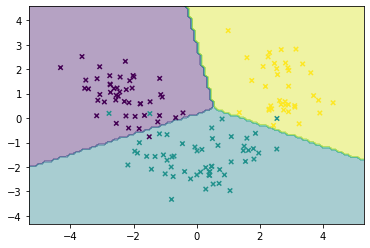

In [300]:
def plot_decision_boundary(cls, x, y):

    x_min, x_max = x[:,0].min() - 1, x[:,0].max() + 1
    y_min, y_max = x[:,1].min() - 1, x[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                        np.arange(y_min, y_max, .1))

    fig, ax = plt.subplots()
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=.4)
    ax.scatter(x[:, 0], x[:, 1], c=y, s=20, edgecolor='k', marker='x');
    return plt

plot_decision_boundary(lr, X_train_pca, y_train);

In [306]:
cross_val_score(lr, X_train_pca, y_train, cv=10, scoring='f1_macro', n_jobs=-1).mean()

0.9737373737373737

In [310]:
X_test_pca = pca.transform(X_test)
cross_val_score(lr, X_test_pca, y_test, cv=10, scoring='f1_macro', n_jobs=-1).mean()

0.9377777777777778

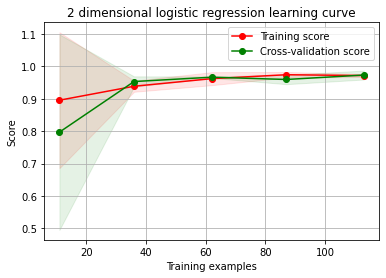

In [311]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, sc='f1_micro', train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig, ax = plt.subplots()

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring=sc)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

    return plt
plot_learning_curve(lr, '2 dimensional logistic regression learning curve', sc='f1_macro', X=X_train_pca, y=y_train);


### We're using the two dimensional projection of our original data here so we can easily visualize the data and model. With the two dimensions we have, we are able to very accurately predict the type of wine we have using our input features.

### Let's now try to create a pipeline version of the model created above. This pipeline will take each transformation step used above and glue the transformations to the classifier. This makes it easier to understand what the model looks like and makes it easier to search for optimal parameters in each step. Let's see what that looks like:

In [312]:
from sklearn import set_config
set_config(display='diagram')

In [313]:
pipe = Pipeline(steps=[
    ('z_scaler', StandardScaler()),
    ('reduce_dim', PCA(n_components=2)),
    ('cls', LogisticRegression(n_jobs=-1, random_state=2, C=1, max_iter=200))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('z_scaler', StandardScaler()),
                ('reduce_dim', PCA(n_components=2)),
                ('cls',
                 LogisticRegression(C=1, max_iter=200, n_jobs=-1,
                                    random_state=2))])

### This pipeline is exactly what we did above: First, we standardize the features, then we reduce the dimensionality, and finally, that data is used to classify the wine type.

### Let's now try to figure out if we can pass the transformers better parameters that will make them predict the type of wine better. Here are the parameters we are going to try. This allows us to indicate what parameters we want to try, and see what combination of all of them works best.

In [314]:
param_grid = {
    'z_scaler__with_mean': [True, False],
    'z_scaler__with_std': [True, False],
    'reduce_dim__n_components': [2],
    'cls__C': [.1, 1, 100],
    'cls__max_iter': [50, 100, 200, 500],
}
search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=5, scoring='f1_micro')
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('z_scaler', StandardScaler()),
                                       ('reduce_dim', PCA(n_components=2)),
                                       ('cls',
                                        LogisticRegression(C=1, max_iter=200,
                                                           n_jobs=-1,
                                                           random_state=2))]),
             n_jobs=-1,
             param_grid={'cls__C': [0.1, 1, 100],
                         'cls__max_iter': [50, 100, 200, 500],
                         'reduce_dim__n_components': [2],
                         'z_scaler__with_mean': [True, False],
                         'z_scaler__with_std': [True, False]},
             scoring='f1_micro')

In [315]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('z_scaler', StandardScaler()),
                                       ('reduce_dim', PCA(n_components=2)),
                                       ('cls',
                                        LogisticRegression(C=1, max_iter=200,
                                                           n_jobs=-1,
                                                           random_state=2))]),
             n_jobs=-1,
             param_grid={'cls__C': [0.1, 1, 100],
                         'cls__max_iter': [50, 100, 200, 500],
                         'reduce_dim__n_components': [2],
                         'z_scaler__with_mean': [True, False],
                         'z_scaler__with_std': [True, False]},
             scoring='f1_micro')

In [316]:
best_pipe = search.best_estimator_
best_pipe

Pipeline(steps=[('z_scaler', StandardScaler()),
                ('reduce_dim', PCA(n_components=2)),
                ('cls',
                 LogisticRegression(C=0.1, max_iter=50, n_jobs=-1,
                                    random_state=2))])

### Out of all the parameters we allowed the model to explore, this produced the best score. The only difference between this pipeline and our above pipelines is that the logistic regression is using more regularization (C=.1 compared to C=1) and it is using fewer iterations to fit the model (max_iter=100 compared to max_iter=50). This model that produced the best score can now be used moving forward. Let's see how this pipeline scores on our training and test set.

In [333]:
train_score = cross_val_score(best_pipe, X_train, y_train, cv=10, n_jobs=-1, scoring='f1_micro').mean()
print(f"Using 10 folds, the cross validation score (F1) of the training set is: {train_score:.2f}")

Using 10 folds, the cross validation score (F1) of the training set is: 0.96


In [334]:
test_score = cross_val_score(best_pipe, X_test, y_test, cv=10, n_jobs=-1, scoring='f1_micro').mean()
print(f"Using 10 folds, the cross validation score (F1) of the test set is: {test_score:.2f}")

Using 10 folds, the cross validation score (F1) of the test set is: 0.97


### Although the train score is slightly lower than before, the test score indicates that the model scores better on unseen data. 

In [320]:
transformer = best_pipe[:-1]
cls = best_pipe[-1]

transformer

Pipeline(steps=[('z_scaler', StandardScaler()),
                ('reduce_dim', PCA(n_components=2))])

In [321]:
cls

LogisticRegression(C=0.1, max_iter=50, n_jobs=-1, random_state=2)

### We can now look at the decision boundary plot for both the testing and training set to visualize what the model is doing.

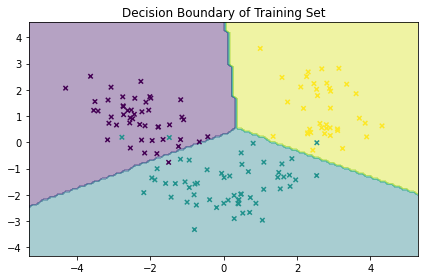

In [328]:
plot_decision_boundary(cls, transformer.transform(X_train), y_train)
plt.title('Decision Boundary of Training Set')
plt.tight_layout();

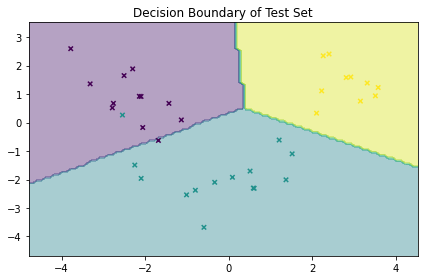

In [329]:
plot_decision_boundary(cls, transformer.transform(X_test), y_test)
plt.title('Decision Boundary of Test Set')
plt.tight_layout();

### These decision boundaries fit the data slightly better as indicated by the train and test scores.

### Now we have seen a brief overview of sklearn pipelines and grid searching for hyperparameters. Let's engineer some new features that may help the model pick up on the different classes a little better. These new features are going to be categorical features so that we can get introduced to some new things one can do with a sklearn pipeline.

### We are going to create four new features based on the existing features. With these new features, we are going to need to process our data differently. 

In [362]:
def level_of_alcohol(val):
    if val >= 12:
        return 'low'
    if val >= 13.8:
        return 'medium'
    else:
        return 'high'

def high_flav_or_not(val):
    if val >= 2:
        return 'high flav'
    else:
        return 'low flav'

def intense_color_or_not(val):
    if val >= 1:
        return 'intense color'
    else:
        return 'not intense color'

def more_phen_than_flavs(df):
    if df['nonflavanoid_phenols'] > df['flavanoids']:
        return 'yes'
    else:
        return 'no'
    
X['high_flav'] = X['flavanoids'].apply(high_flav_or_not)
X['intense_color'] = X['color_intensity'].apply(intense_color_or_not)
X['more_phen_than_flavs'] = X.apply(more_phen_than_flavs, axis=1)
X['level_of_alcohol'] = X['alcohol'].apply(level_of_alcohol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)


### Now that we have created these new features and split the data again, let's take a look at the data.

In [363]:
X_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,high_flav,intense_color,more_phen_than_flavs,level_of_alcohol
84,11.84,0.89,2.58,18.0,94.0,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520.0,high flav,intense color,no,high
11,14.12,1.48,2.32,16.8,95.0,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280.0,high flav,intense color,no,low
168,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0,low flav,intense color,no,low
138,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0,low flav,intense color,yes,low
86,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,low flav,intense color,no,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,14.10,2.02,2.40,18.8,103.0,2.75,2.92,0.32,2.38,6.20,1.07,2.75,1060.0,high flav,intense color,no,low
125,12.07,2.16,2.17,21.0,85.0,2.60,2.65,0.37,1.35,2.76,0.86,3.28,378.0,high flav,intense color,no,low
137,12.53,5.51,2.64,25.0,96.0,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515.0,low flav,intense color,yes,low
158,14.34,1.68,2.70,25.0,98.0,2.80,1.31,0.53,2.70,13.00,0.57,1.96,660.0,low flav,intense color,no,low


### We can see the new features in the dataset. Each of the datapoints for these new features are string values. In order to include categorical features in our model, we are going to need to transform them to some numeric representation. Let's import the necessary tools for that.

In [364]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

In [365]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 84 to 106
Data columns (total 17 columns):
alcohol                         142 non-null float64
malic_acid                      142 non-null float64
ash                             142 non-null float64
alcalinity_of_ash               142 non-null float64
magnesium                       142 non-null float64
total_phenols                   142 non-null float64
flavanoids                      142 non-null float64
nonflavanoid_phenols            142 non-null float64
proanthocyanins                 142 non-null float64
color_intensity                 142 non-null float64
hue                             142 non-null float64
od280/od315_of_diluted_wines    142 non-null float64
proline                         142 non-null float64
high_flav                       142 non-null object
intense_color                   142 non-null object
more_phen_than_flavs            142 non-null object
level_of_alcohol                142 non-null obje

### As we can see, the new features are of 'object' datatype. We can select these using the select_dtypes dataframe method.

In [366]:
X_train.select_dtypes('object')

,high_flav,intense_color,more_phen_than_flavs,level_of_alcohol
84,high flav,intense color,no,high
11,high flav,intense color,no,low
168,low flav,intense color,no,low
138,low flav,intense color,yes,low
86,low flav,intense color,no,low
...,...,...,...,...
48,high flav,intense color,no,low
125,high flav,intense color,no,low
137,low flav,intense color,yes,low
158,low flav,intense color,no,low


### At a high level, what were going to need to do is split off the numeric data from the categorical data, process them in different ways, and then join back the transformed data together before passing it to a classifier.

In [367]:
cat_cols = X_train.select_dtypes('object').columns
print(cat_cols)
num_cols = X_train.select_dtypes(['float', 'int']).columns
print()
print(num_cols)


Index(['high_flav', 'intense_color', 'more_phen_than_flavs',
       'level_of_alcohol'],
      dtype='object')

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')


In [368]:
X_train.select_dtypes(['float', 'int'])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
84,11.84,0.89,2.58,18.0,94.0,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520.0
11,14.12,1.48,2.32,16.8,95.0,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280.0
168,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0
138,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0
86,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,14.10,2.02,2.40,18.8,103.0,2.75,2.92,0.32,2.38,6.20,1.07,2.75,1060.0
125,12.07,2.16,2.17,21.0,85.0,2.60,2.65,0.37,1.35,2.76,0.86,3.28,378.0
137,12.53,5.51,2.64,25.0,96.0,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515.0
158,14.34,1.68,2.70,25.0,98.0,2.80,1.31,0.53,2.70,13.00,0.57,1.96,660.0


### The following code is identifying how we want to process our numeric data, how we want to process our categorical data, and then using what's called a column transformer to stack those two transformers horizontally. Although you may not understand what I mean when I say that we are going to join these two transformers horizontally, it will become clear shortly. 

### When using a column transformer, one must specify the pipelines that will transform the data and also must specify which columns each transformer gets. Once we have our two transformers that know what columns to operate on, we can create a final pipeline that first transforms the data, and subsequently classifies it.

In [369]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=False)),
    ('onehot', OneHotEncoder(drop=None)),
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=False)),
    ('z_scaler', StandardScaler(with_mean=True, with_std=True)),
    ('poly', PolynomialFeatures(degree=2))
])

transformer = ColumnTransformer(transformers=[
    ('cat_transformer', categorical_transformer, cat_cols),
    ('num_transformer', numeric_transformer, num_cols)
])

pipe = Pipeline(steps=[
    ('transformer', transformer),
    ('cls', LogisticRegression(C=1, n_jobs=-1))
])
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['high_flav', 'intense_color', 'more_phen_than_flavs',
       'level_of_alcohol'],
      dtype='object')),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('z_scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object'))])),
                ('cls', LogisticRegression(C=1, n_jobs=-1))])

### As you can see from the above visualization, the categorical variables are going through one form of transformation and the numeric variables are going through another form of transformation. As the lines indicate, each column will be transformed depending on its datatype and then will be joined togehter and passed to a classifier (logistic regression). Let's fit our data to this new pipeline.

In [370]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['high_flav', 'intense_color', 'more_phen_than_flavs',
       'level_of_alcohol'],
      dtype='object')),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('z_scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object'))])),
                ('cls', LogisticRegression(C=1, n_jobs=-1))])

In [373]:
test_score = cross_val_score(cls, transformer.transform(X_test), y_test, cv=5, n_jobs=-1, scoring='f1_micro').mean()
print(f"The test F1 score is: {test_score:.2f}")

The test F1 score is: 0.97


### This new pipeline is able to process our categorical data and also adds an additional transformation on to the numeric transformer. The beauty of these pipelines is that you only have to specify the way the data pipeline works once and can just use this object moving forward rather than having to specify each individual transformation each time you want to predict on new data or train the model again. Let's try to find out if there are any parameters that might help the model out using the grid searching teachnique outlined above. We can try out different parameters for each individual component and figure out which combination of parameters is going to work best for our circumstances.

### We can also try different parameter grids including different classifiers. Each dictionary element in this list specifys a different grid we want to seach through. The best pipeline will be whichever combination was best. Here we are seeing if a random forest classifier would work better than a logistic regression here.

In [374]:
param_grid = [{
    'transformer__cat_transformer__onehot__drop': [None, 'first'],
    'transformer__cat_transformer__imputer__add_indicator': [True, False],
    'transformer__num_transformer__imputer__add_indicator': [True, False],
    'transformer__num_transformer__imputer__strategy': ['mean', 'median'],
    'transformer__num_transformer__z_scaler__with_mean': [True, False],
    'transformer__num_transformer__z_scaler__with_std': [True, False],
    'transformer__num_transformer__poly__degree': np.arange(1, 3),
    'cls__C': [0.01, 0.5, 1, 3],
},
    {
     'cls': [RandomForestClassifier(n_jobs=-1)],
    'cls__min_samples_leaf': [1, 2, 3],
    'cls__n_estimators': [100, 200, 500]
}
        ]

In [376]:
search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         Index(['high_flav', 'intense_color', 'more_phen_than_flavs',
       'level_of_alcohol'],
      dtype='object')),
                                                                        ('num_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleI...
                          'transformer__num_transformer__imputer__strategy': ['mean',
                                                                              'median'],
                          'transformer__num_transformer__poly__degree': array([1, 2]),
                          'transformer__num_transformer__z_scaler__with_mean': [True,
                                                                                False],
                          'transformer__num_transformer__z_scaler__with_std': [True,
                                                                               False]},
                         {'cls': [RandomForestClassifier(n_jobs=-1)],
                          'cls__min_samples_leaf': [1, 2, 3],
                          'cls__n_estimators': [100, 200, 500]}])

In [377]:
best_pipe = search.best_estimator_
best_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['high_flav', 'intense_color', 'more_phen_than_flavs',
       'level_of_alcohol'],
      dtype='object')),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImput...
                                                                  ('z_scaler',
                                                                   StandardScaler(with_mean=False)),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1))]),
                                                  Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object'))])),
                ('cls', LogisticRegression(C=1, n_jobs=-1))])

In [382]:
transformer = best_pipe[:-1]
cls = best_pipe[-1]

train_score = cross_val_score(cls, transformer.transform(X_train), y_train, scoring='f1_micro', cv=5, n_jobs=-1).mean()
test_score = cross_val_score(cls, transformer.transform(X_test), y_test, scoring='f1_micro', cv=5, n_jobs=-1).mean()
print(f"The training score of this model is: {train_score:.2f}")
print()
print(f"The testing score of this model is: {test_score:.2f}")

The training score of this model is: 0.99

The testing score of this model is: 0.97


### It looks like with the new categorical features and the new way of processing the data, we were able to achieve a slightly better fit and thus a slightly better score. 

### From this tutorial, I hope you've learned:
### 1) How to use a sklearn pipeline
### 2) How to use sklearn pipelines in conjunction with grid search objects to search for optimal hyperparameters
### 3) How to use sklearn pipelines and grid searching to choose between different modeling approaches
### 4) How to use column transformers to process categorical data and numeric data differently